**0) Lý thuyết và nguồn dữ liệu** <br>
Nguồn dữ liệu được lấy từ trang web: https://github.com/stefan-it/nmt-en-vi/tree/master/data

Lý thuyết tham khảo ở các tài liệu:


1.   Cho, K., Van Merriënboer, B., Bahdanau, D., & Bengio, Y. (2014). On the properties of neural machine translation: Encoder-decoder approaches. arXiv preprint arXiv:1409.1259.
2.   Rico Sennrich, Barry Haddow (2016). Linguistic Input Features Improve Neural Machine Translation.



**1) Chuẩn bị thư viện và dữ liệu**

Đầu tiên ta sẽ chuẩn bị một số thư viện

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
!pip install unidecode
import unidecode
import string
import re
import random
import numpy as np
import html

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

     |████████████████████████████████| 245kB 2.7MB/s 


Chuẩn bị dữ liệu cho chương trình

In [2]:
!git clone https://github.com/nguyenduyhanlam/PTXS-GTNN
!ls
import os
os.getcwd()

Cloning into 'PTXS-GTNN'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 60 (delta 31), reused 41 (delta 12), pack-reused 0
Unpacking objects: 100% (60/60), done.
PTXS-GTNN  sample_data


'/content'

Ta cần chuẩn bị thêm thư viện phục vụ cho việc lemmas hóa.

In [3]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


**2) Load dữ liệu** <br>
Ta sẽ tạo class ngôn ngữ dùng để load dữ liệu từ file text. <br>
Class ngôn ngữ gồm có các **thuộc tính** cơ bản sau:
*   **name**: tên của ngôn ngữ (English, tiếng Việt,...)
*   **word2index**: bộ từ điển.
*   **word2count**: bộ đếm từ.
*   **index2word**: bộ lưu vị trí các token.
*   **n_words**: đếm tổng các lượng từ.

Class ngôn ngữ gồm có các **hàm** cơ bản sau:
*   **addSentence**: Có tham số là sentence, dùng để truyền vào 1 câu văn bản. Từ câu văn bản này, ta sẽ tách thành các từ (word). Cuối cùng ta sẽ lưu các từ này vào bộ từ điển bằng hàm addWord.
*   **addWord**: Có tham số là word, dùng để truyền vào 1 từ (word), nếu từ này chưa có trong bộ từ điển thì sẽ được thêm (add) mới vào bộ từ điển. Nếu đã có rồi ta sẽ tăng số lần xuất hiện (số đếm) của từ này thêm 1 đơn vị.








In [0]:
SOS_token = 0 #Start Of Sequence
EOS_token = 1 #End Of Sequence
PAD_token = 2 # Used for padding short sentences

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

Ta cần triển khai thêm một số hàm bổ trợ như:
*   **remove_accent**: dùng để loại bỏ các dấu thanh (sắc, hỏi, huyền, ngã, nặng,...).
*   **normalizeString**: Dùng để chuẩn hóa câu để chạy chương trình. Đầu tiên ta sẽ loại bỏ hết các dấu thanh ra khỏi câu. Sau đó ta sẽ tách các dấu câu (dấu phẩy, dấu chấm, dấu chấm hỏi, dấu chấm thang,...) ra khỏi từ. Ngoài ra ta sẽ chuyển bớt một số dạng thể ngắn của tiếng anh về dạng thường.

Ví dụ ta có câu: "Ăn quả, nhớ kẻ trồng cây.". Sau khi chạy hàm **normalizeString** ta sẽ được kết quả là: "An qua , nho ke trong cay ."



In [5]:
# remove all the accents
def remove_accent(utf8_str):
    return unidecode.unidecode(utf8_str)

contractions = {
"ain 't": "am not / are not",
"aren 't": "are not / am not",
"can 't": "cannot",
"can 't 've": "cannot have",
"'cause": "because",
"could 've": "could have",
"couldn 't": "could not",
"couldn 't 've": "could not have",
"didn 't": "did not",
"doesn 't": "does not",
"don 't": "do not",
"hadn 't": "had not",
"hadn 't 've": "had not have",
"hasn 't": "has not",
"haven 't": "have not",
"he 'd": "he had / he would",
"he 'd 've": "he would have",
"he 'll": "he shall / he will",
"he 'll 've": "he shall have / he will have",
"he 's": "he has / he is",
"how'd": "how did",
"how'd 'y": "how do you",
"how 'll": "how will",
"how 's": "how has / how is",
"i 'd": "I had / I would",
"i 'd 've": "I would have",
"i 'll": "I shall / I will",
"i 'll 've": "I shall have / I will have",
"i 'm": "I am",
"i 've": "I have",
"isn 't": "is not",
"it 'd": "it had / it would",
"it 'd've": "it would have",
"it 'll": "it shall / it will",
"it 'll've": "it shall have / it will have",
"it 's": "it has / it is",
"let 's": "let us",
"ma 'am": "madam",
"mayn 't": "may not",
"might 've": "might have",
"mightn 't": "might not",
"mightn 't 've": "might not have",
"must 've": "must have",
"mustn 't": "must not",
"mustn 't 've": "must not have",
"needn 't": "need not",
"needn 't 've": "need not have",
"o 'clock": "of the clock",
"oughtn 't": "ought not",
"oughtn 't 've": "ought not have",
"shan 't": "shall not",
"sha 'n 't": "shall not",
"shan 't 've": "shall not have",
"she 'd": "she had / she would",
"she 'd've": "she would have",
"she 'll": "she shall / she will",
"she 'll've": "she shall have / she will have",
"she 's": "she has / she is",
"should 've": "should have",
"shouldn 't": "should not",
"shouldn 't 've": "should not have",
"so 've": "so have",
"so 's": "so as / so is",
"that 'd": "that would / that had",
"that 'd 've": "that would have",
"that 's": "that has / that is",
"there 'd": "there had / there would",
"there 'd 've": "there would have",
"there 's": "there has / there is",
"they 'd": "they had / they would",
"they 'd 've": "they would have",
"they 'll": "they shall / they will",
"they 'll 've": "they shall have / they will have",
"they 're": "they are",
"they 've": "they have",
"to 've": "to have",
"wasn 't": "was not",
"we 'd": "we had / we would",
"we 'd 've": "we would have",
"we 'll": "we will",
"we 'll 've": "we will have",
"we 're": "we are",
"we 've": "we have",
"weren 't": "were not",
"what 'll": "what shall / what will",
"what 'll 've": "what shall have / what will have",
"what 're": "what are",
"what 's": "what has / what is",
"what 've": "what have",
"when 's": "when has / when is",
"when 've": "when have",
"where 'd": "where did",
"where 's": "where has / where is",
"where 've": "where have",
"who 'll": "who shall / who will",
"who 'll 've": "who shall have / who will have",
"who 's": "who has / who is",
"who 've": "who have",
"why 's": "why has / why is",
"why 've": "why have",
"will 've": "will have",
"won 't": "will not",
"won 't 've": "will not have",
"would 've": "would have",
"wouldn 't": "would not",
"wouldn 't 've": "would not have",
"y 'all": "you all",
"y 'all 'd": "you all would",
"y 'all 'd 've": "you all would have",
"y 'all 're": "you all are",
"y 'all 've": "you all have",
"you 'd": "you had / you would",
"you 'd 've": "you would have",
"you 'll": "you shall / you will",
"you 'll 've": "you shall have / you will have",
"you 're": "you are",
"you 've": "you have"
}

# Normalize the string (marks and words are seperated, words don't contain accents,...)
def normalizeString(s):
    # Remove all the accents first.
    s = remove_accent(html.unescape(s))
    # Seperate words and marks by adding spaces between them
    marks = '[.!?,-${}()]'
    r = "(["+"\\".join(marks)+"])"
    s = re.sub(r, r" \1 ", s)
    # replace continuous spaces with a single space
    s = re.sub(r"\s+", r" ", s).strip()
    
    # Convert to writing form
    for c in contractions:
        if c in s:
            s = s.replace(c, contractions[c].lower())

    return s

# Example
ex_s = "Ăn quả, nhớ kẻ trồng cây."
print(normalizeString(ex_s)) # result will be "An qua , nho ke trong cay ."

An qua , nho ke trong cay .


Cuối cùng ta sẽ thực hiện việc load dữ liệu.

In [6]:
def readLangs(lang1, lang2):
    print("Reading lines...")

    # Read the file and split into lines
    lines_language1 = open('PTXS-GTNN/train.%s' % lang1, encoding='utf-8').\
        read().strip().split('\n')
    lines_language2 = open('PTXS-GTNN/train.%s' % lang2, encoding='utf-8').\
        read().strip().split('\n')

    # Normalize all the lines
    data_language1 = [normalizeString(l.lower().strip()) for l in lines_language1]
    data_language2 = [normalizeString(l.lower().strip()) for l in lines_language2]

    # Prepare return values
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)
    data = list(zip(data_language1, data_language2))

    return input_lang, output_lang, data

# Test the function
lang1 = "en"
lang2 = "vi"
input_lang, output_lang, data = readLangs(lang1, lang2)
print("Language 1:", input_lang.name)
print("Language 2:", output_lang.name)
print(random.choice(data))

Reading lines...
Language 1: en
Language 2: vi
('we have vast budget deficits .', 'chung ta dang tham hut ngan sach tram trong .')


**3) Chuẩn bị dữ liệu** <br>


Chương trình sẽ chạy nhanh hơn khi chúng ta lọc bộ dữ liệu thành các câu ngắn và đơn giản. Ở đây ta sẽ giới hạn cho 1 câu có tối đa là 10 từ (bao gồm cả dấu chấm câu). Đồng thời ta viết hàm thực hiện lemmatization.

In [0]:
MAX_LENGTH = 10

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def lemmatizer(sentence):
    for word in sentence.split():
        sentence = sentence.replace(word, wordnet_lemmatizer.lemmatize(word, pos="v"))
    return sentence

Sau quá trình biến đổi chúng ta sẽ có được tập dữ liệu để chuẩn bị cho huấn luyện.

In [8]:
def prepareData(lang1, lang2):
    input_lang, output_lang, pairs = readLangs(lang1, lang2)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        # Lemmatization process
        inWord = lemmatizer(pair[0])
        outWord = lemmatizer(pair[1])
        # Add word to dictionaries after lemmatization
        input_lang.addSentence(inWord)
        output_lang.addSentence(outWord)
    print("Counted words:")
    print("Language 1:", input_lang.name, "There are", input_lang.n_words, "different words")
    print("Language 2:", output_lang.name, "There are", output_lang.n_words, "different words")
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('en', 'vi')
print(random.choice(pairs))

Reading lines...
Read 133317 sentence pairs
Trimmed to 14655 sentence pairs
Counting words...
Counted words:
Language 1: en There are 7111 different words
Language 2: vi There are 3114 different words
('we did it for the amazon region .', 'chung toi thuc hien o vung amazon .')


**4) Mô hình Encoder-Decoder**

Đầu tiên ta sẽ đi xây dưng bộ encoder trước.

---

===================================**Encoder**===================================

Mô hình encoder như sau:

![Encoder example](https://drive.google.com/uc?id=1cyor63sz5r_-hnwXvptVDl_4-3ltsKzC)

(Source: https://medium.com/@t.schnake/a-formalization-of-a-simple-sequential-encoder-decoder-b31be7e92988)

![Pytorch encoder flow](https://drive.google.com/uc?id=1R5dtbS_Xl4wYZMJcL4BT47VEGX-lMMXR)

(Source: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)

Ta sẽ đi xây dựng một class có tên là EncoderRNN cho bộ GRU-RNN encoder.

Class này có các thuộc tính cơ bản sau:
*   **hidden_size**: kích thước (số chiều) của vector của mỗi phần tử trong bộ từ điển.
*   **embedding**: lưu trữ kết quả của bộ từ điển sau khi thực hiện word embedding (tham khảo thêm về word embedding tại https://machinelearningmastery.com/what-are-word-embeddings/).
*   **gru**: cấu trúc GRU sẽ sử dụng.

Trong hàm khởi tạo ta sẽ truyền vào các biến sau:
*   **input_size**: kích thước của bộ từ điển (số lượng từ có trong bộ từ điển).
*   **hidden_size**: kích thước (số chiều) của vector của mỗi phần tử trong bộ từ điển.

In [0]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        
        # A simple lookup table that stores embeddings of a fixed dictionary 
        # and size. 
        # This module is often used to store word embeddings and retrieve them using indices. 
        # The input to the module is a list of indices, 
        # and the output is the corresponding word embeddings.
        # input_size: num_embeddings (python:int) – size of the dictionary of embeddings
        # hidden_size: embedding_dim (python:int) – the size of each embedding vector
        self.embedding = nn.Embedding(input_size, hidden_size)
        
        # Applies a multi-layer gated recurrent unit (GRU) RNN to an input sequence.
        # hidden_size: input_size – The number of expected features in the input x
        # hidden_size: hidden_size – The number of features in the hidden state h
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        # Create word embedding table based on the data -> tensor table
        # view(*shape): Returns a new tensor with the same data as the self tensor but of a different shape.
        embedded = self.embedding(input).view(1, 1, -1)

        output = embedded

        # Execute GRU process
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        # Initiate the first hidden unit
        return torch.zeros(1, 1, self.hidden_size, device=device)

===================================**Decoder**===================================

Mô hình decoder cơ bản có thể được minh họa như sau:

![Decoder example](https://drive.google.com/uc?id=15k-FuqT8oCaP3MkHV7W-5OQg072OzQsz)

(Source: https://medium.com/@t.schnake/a-formalization-of-a-simple-sequential-encoder-decoder-b31be7e92988)

![Pytorch base decoder flow](https://drive.google.com/uc?id=16Mt0xS53HsAczMiwZYbcBRC0x95wA_og)

(Source: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)

Class này có các thuộc tính cơ bản sau:
*   **hidden_size**: kích thước (số chiều) của vector của mỗi phần tử trong tập kết quả của encoder.
*   **embedding**: lưu trữ kết quả của bộ vector kết quả từ encoder sau khi thực hiện word embedding (tham khảo thêm về word embedding tại https://machinelearningmastery.com/what-are-word-embeddings/).
*   **gru**: cấu trúc GRU sẽ sử dụng.
*   **out**: đối tượng linear transformation.
*   **softmax**: đối tượng softmax.

Trong hàm khởi tạo ta sẽ truyền vào các biến sau:
*   **hidden_size**: kích thước (số chiều) của vector của mỗi phần tử trong tập kết quả của encoder.
*   **output_size**: kích thước của kết quả đầu ra.

In [0]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        # A simple lookup table that stores embeddings of a fixed dictionary 
        # and size. 
        # This module is often used to store word embeddings and retrieve them using indices. 
        # The input to the module is a list of indices, 
        # and the output is the corresponding word embeddings.
        # output_size: num_embeddings (python:int) – size of the dictionary of embeddings
        # hidden_size: embedding_dim (python:int) – the size of each embedding vector
        self.embedding = nn.Embedding(output_size, hidden_size)

        # Applies a multi-layer gated recurrent unit (GRU) RNN to an input sequence.
        # hidden_size: input_size – The number of expected features in the input x
        # hidden_size: hidden_size – The number of features in the hidden state h
        self.gru = nn.GRU(hidden_size, hidden_size)

        # Applies a linear transformation to the incoming data: y = xA^T + b
        # hidden_size: in_features – size of each input sample
        # output_size: out_features – size of each output sample
        self.out = nn.Linear(hidden_size, output_size)
        
        # Applies the log(Softmax(x) function to an n-dimensional input Tensor. The LogSoftmax formulation can be simplified as:
        # logSoftmax(xi) = log(exp(xi) / sum_j(exp(xj)))
        # dim=1: Input: (*) where * means, any number of additional dimensions
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # Create word embedding table based on the data -> tensor table
        # view(*shape): Returns a new tensor with the same data as the self tensor but of a different shape.
        output = self.embedding(input).view(1, 1, -1)
        
        # Assuring the encoder output is not negative
        # Because ReLU output range is (0, +inf)
        output = F.relu(output)

        # Execute GRU process
        output, hidden = self.gru(output, hidden)

        # Calculate the softmax
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        # Initiate the first hidden unit
        return torch.zeros(1, 1, self.hidden_size, device=device)

**Decoder sử dụng attention**

Attention là một cơ chế kỹ thuật nhằm giúp giải quyết các giới hạn của kiến trúc encoder-decoder trên các chuỗi dài (chuỗi dữ liệu đầu vào). Attention sẽ giúp tăng tốc độ học tập và cải thiện khả năng dự đoán của mô hình.

Do vector ngữ cảnh này có độ dài cố định và là kết quả sau quá trình mã hóa từ dữ liệu đầu vào có độ dài thay đổi, nên vector này sẽ chứa rất nhiều thông tin. Việc mã hóa (decode) vector này sẽ là một áp lực lớn đối với decoder.

Cơ chế attention cho phép tại mỗi bước input của decoder, decoder có thể tập trung vào từng phần khác nhau của encoder output. Đầu tiên, chúng ta sẽ tính tập trọng số attention (attention weight). Sau đó ta sẽ lấy tập trọng số này nhân với các vectơ đầu ra của encoder để tạo ra một tổ hợp có trọng số. Kết quả (được gọi là attn_applied) này giúp nhận biết được từng phần của chuỗi đầu vào, và từ đó sẽ giúp decoder chọn được từ (word) đầu ra đúng.

Thay vì mã hóa chuỗi đầu vào thành một vectơ ngữ cảnh cố định duy nhất, mô hình chú ý phát triển một vectơ bối cảnh được lọc riêng cho từng bước thời gian t ở đầu ra.

![Attention](https://drive.google.com/uc?id=1uK8t6wEnWEfpC4osuankfgH7WMXrx4ec)

(Source: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)


In [0]:
print("Source: https://towardsdatascience.com/attn-illustrated-attention-5ec4ad276ee3")
from IPython.display import Image
Image(url='https://miro.medium.com/max/576/1*wBHsGZ-BdmTKS7b-BtkqFQ.gif')

Source: https://towardsdatascience.com/attn-illustrated-attention-5ec4ad276ee3


Ta sẽ đi xây dựng class decoder có sử dụng attention.

![alt text](https://drive.google.com/uc?id=1MZ4vaGKFX5Q8cd-Z40i-rYRHg2yh5pDd)

(Source: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)

Class này có các thuộc tính cơ bản sau:
*   **hidden_size**: kích thước (số chiều) của vector của mỗi phần tử trong tập kết quả của encoder.
*   **output_size**: kích thước của đầu ra.
*   **dropout_p**: xác suất loại bỏ.
*   **max_length**: số lượng từ giới hạn cho 1 câu dịch.
*   **embedding**: lưu trữ kết quả của bộ vector kết quả từ encoder sau khi thực hiện word embedding (tham khảo thêm về word embedding tại https://machinelearningmastery.com/what-are-word-embeddings/).
*   **attn**: đối tượng attention khởi tạo.
*   **attn_combine**: đối tượng kết hợp attention.
*   **dropout**: Trong quá trình đào tạo, gán ngẫu nhiên giá trị 0 cho một vài phần tử của decoder input với xác suất p theo phân phối Bernoulli (tiếng việt: https://maths.uel.edu.vn/Resources/Docs/SubDomain/maths/TaiLieuHocTap/ToanUngDung/phn_phi_bernoulli.html, tiếng anh: https://en.wikipedia.org/wiki/Bernoulli_distribution). Mỗi channel sẽ được 0 hóa độc lập trong mỗi lần forward (lan truyền tiến). Đây đã được chứng minh là một kỹ thuật hiệu quả để chuẩn hóa (regularization) và ngăn chặn sự đồng thích ứng (co-adaptation) của các nơ-ron thần kinh như được mô tả trong bài viết https://arxiv.org/pdf/1207.0580.pdf. Hơn nữa, các đầu ra được chia tỷ lệ theo hệ số 1 / (1-p) trong quá trình đào tạo. Điều này có nghĩa là trong quá trình đánh giá, mô-đun chỉ cần tính toán một hàm identity.
*   **gru**: cấu trúc GRU sẽ sử dụng.
*   **out**: đối tượng linear transformation.

Trong hàm khởi tạo ta sẽ truyền vào các biến sau:
*   **hidden_size**: kích thước (số chiều) của vector của mỗi phần tử trong tập kết quả của encoder.
*   **output_size**: kích thước của kết quả đầu ra.
*   **dropout_p**: xác suất loại bỏ.
*   **max_length**: số lượng từ giới hạn cho 1 câu dịch.

In [0]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        # A simple lookup table that stores embeddings of a fixed dictionary 
        # and size. 
        # This module is often used to store word embeddings and retrieve them using indices. 
        # The input to the module is a list of indices, 
        # and the output is the corresponding word embeddings.
        # output_size: num_embeddings (python:int) – size of the dictionary of embeddings
        # hidden_size: embedding_dim (python:int) – the size of each embedding vector
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)

        # Applies a linear transformation to the incoming data: y = xA^T + b
        # hidden_size * 2: in_features – size of each input sample
        # max_length: out_features – size of each output sample
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)

        # Applies a linear transformation to the incoming data: y = xA^T + b
        # hidden_size * 2: in_features – size of each input sample
        # hidden_size: out_features – size of each output sample
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)

        # During training, randomly zeroes some of the elements of 
        # the input tensor with probability p 
        # using samples from a Bernoulli distribution. 
        # Each channel will be zeroed out independently on every forward call.
        # This has proven to be an effective technique for regularization 
        # and preventing the co-adaptation of neurons 
        # as described in the paper Improving neural networks by preventing co-adaptation of feature detectors .
        # Furthermore, the outputs are scaled by a factor of 1/(1-p) 
        # during training. This means that during evaluation the module simply computes an identity function.
        # dropout_p: p – probability of an element to be zeroed. Default (when don't have parameter): 0.5
        # In this constructor, the default parameter (probability) is 0.1
        self.dropout = nn.Dropout(self.dropout_p)

        # Applies a multi-layer gated recurrent unit (GRU) RNN to an input sequence.
        # hidden_size: input_size – The number of expected features in the input x
        # hidden_size: hidden_size – The number of features in the hidden state h
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        
        # Applies a linear transformation to the incoming data: y = xA^T + b
        # hidden_size: in_features – size of each input sample
        # output_size: out_features – size of each output sample
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        # Create word embedding table based on the data -> tensor table
        # view(*shape): Returns a new tensor with the same data as the self tensor but of a different shape.
        embedded = self.embedding(input).view(1, 1, -1)
        
        # Execute dropout process
        embedded = self.dropout(embedded)

        # Execute attention process
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        # Performs a batch matrix-matrix product
        # unsqueeze: Returns a new tensor with a dimension of size one inserted at the specified position.
        #            The returned tensor shares the same underlying data with this tensor.
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        # Assuring the encoder output is not negative
        # Because ReLU output range is (0, +inf)
        output = F.relu(output)

        # Execute GRU process
        output, hidden = self.gru(output, hidden)

        # Calculate the softmax
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        # Initiate the first hidden unit
        return torch.zeros(1, 1, self.hidden_size, device=device)

**5) Chuẩn bị quá trình huấn luyện**

Để huấn luyện, đối với mỗi cặp, chúng ta sẽ cần một tensor (vector) đầu vào (index của các từ trong câu) và tensor đích (index của các từ trong câu đích). Trong khi tạo các vector này, ta sẽ nối thêm mã thông báo EOS vào cả hai chuỗi.

In [0]:
def indexesFromSentence(lang, sentence):
    # Get the counter for each word in the sentence
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    # Get the counter
    indexes = indexesFromSentence(lang, sentence)
    # Append token to the end of the array
    indexes.append(EOS_token)
    # Return the vector
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    # Create input vector
    input_tensor = tensorFromSentence(input_lang, lemmatizer(pair[0]))
    # Create output vector
    target_tensor = tensorFromSentence(output_lang, lemmatizer(pair[1]))
    # Return result
    return (input_tensor, target_tensor)

**6) Quá trình huấn luyện**

Để đào tạo, ta sẽ đưa dữ liệu đầu vào đi qua encoder, ta sẽ tiến hành theo dõi các kết quả đầu ra cũng như các giá trị trạng thái ẩn của encoder. Sau đó, ta sẽ cung cấp cho decoder token thông báo <SOS> làm tín hiệu thông báo cho decoder khởi tạo đầu vào đầu tiên, đồng thời trạng thái ẩn cuối cùng của encoder sẽ làm trạng thái ẩn đầu tiên cho decoder.

"Teacher forcing" là một khái niệm ám chỉ về việc ta sẽ sử dụng các giá trị đầu ra mong muốn cho mỗi đầu vào tiếp theo, thay vì ta sử dụng kết quả mà decoder dự đoán được cho các đầu vào tiếp theo. Việc làm này sẽ khiến cho chương trình hội tụ nhanh hơn, trong một số trường hợp việc làm dụng điều này sẽ khiến cho chương trình không ổn định (tham khảo thêm: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.378.4095&rep=rep1&type=pdf).

Theo trực giác, ta có thể quan sát kết quả đầu ra của các mạng "teacher-forcing" có cấu trúc ngữ pháp ổn định tuy nhiên kết quả dịch lại không được chính xác. Điều này cho thấy rằng mạng "teacher-forcing" có thể học được cấu trúc ngữ pháp, tuy nhiên việc dịch nghĩa của nó lại không được tốt.

In [0]:
teacher_forcing_ratio = 0.5

# Training function
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    
    # Intiatie encoder process
    encoder_hidden = encoder.initHidden()

    # Clears the gradients of all optimized torch.Tensor.
    encoder_optimizer.zero_grad()
    # Clears the gradients of all optimized torch.Tensor.
    decoder_optimizer.zero_grad()

    # Save input tensor size
    input_length = input_tensor.size(0)
    # Save output tensor size
    target_length = target_tensor.size(0)

    # Initiate encoder output
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    # Initiate loss value
    loss = 0

    # for each encoder input
    for ei in range(input_length):
        # Execute encoder process
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        # Save encoder result
        encoder_outputs[ei] = encoder_output[0, 0]

    # Initiate decoder input
    decoder_input = torch.tensor([[SOS_token]], device=device)

    # Assign encoder result to the 1st decoder hidden unit
    decoder_hidden = encoder_hidden

    # Randomly using teacher_forcing feature
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            # Execute decoder process
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # Add loss
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            # Execute decoder process
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            # Add loss
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    # Backpropagation
    loss.backward()

    # Performs a single optimization step.
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

Ta có thể theo dõi lượng thời gian chương trình tiến hành huấn luyện bằng một số hàm sau:

In [0]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

Ta viết thêm hàm vẽ biểu đồ biểu diễn sự thay đổi của giá trị loss

In [0]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Toàn bộ quá trình đào tạo trông như thế này:
*   Bắt đầu tính thời gian huấn luyện.
*   Khởi tạo bộ tối ưu hóa (optimizer) và bộ tiêu chuẩn (criterion).
*   Tạo một tập các cặp đào tạo (training pair).
*   Khởi tạo mảng loss lưu từng giá trị loss tại các thời điểm nhằm phục vụ cho việc vẽ biểu đồ.

Cuối cùng ta sẽ gọi hàm train để thực hiện quá trình đào tạo. Kết thúc 1 lượt đào tạo ta sẽ thông báo một vài giá trị như giá trị mất mát (loss) trung bình hiện tại, thời gian huấn luyện hiện tại,...

In [0]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    # Implements stochastic gradient descent (optionally with momentum).
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    # Randomly choose some pairs in the dataset for training process
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    # The negative log likelihood loss.
    # The input given through 
    # a forward call is expected to contain log-probabilities of each class. 
    # Input has to be a Tensor of size either (minibatch,C)
    # or or (minibatch, C, d1, d2, ..., dK) with K≥1 for the K-dimensional case.
    # Default: loss = sum((1/sum(w_(y_n))) * loss_n), loss_n = -w*x_(n,y_n)
    criterion = nn.NLLLoss()

    # for each sample
    for iter in range(1, n_iters + 1):
        # Get input data and target data
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        
        # Execute training process
        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        # Print info
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    # Draw plot
    showPlot(plot_losses)

**7) Đánh giá (evaluation)**

Quá trình đánh giá chủ yếu cũng gần giống như đào tạo, tuy nhiên nó khác với quá trình đào tạo ở chỗ nó sẽ không đi so sánh giữa kết quả dự đoán với giá trị mong muốn (target data). Quá trình đánh giá đơn giản chỉ là ta sẽ đem các giá trị dự đoán mà decoder đã thực hiện được nạp vào lại chính nó tại mỗi bước. Mỗi lần decoder dự đoán một từ, ta sẽ thêm từ đó vào chuỗi đầu ra, khi decoder dự đoán mã thông báo (token) EOS, ta sẽ tiến hành dừng quá trình thực hiện. Chúng ta cũng nên cần lưu trữ các giá trị đầu ra của decoder attention nhằm phục vụ cho các yêu cầu hiển thị về sau.

In [0]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    # Disable the gradient computation.
    with torch.no_grad():
        # Get input sample
        input_tensor = tensorFromSentence(input_lang, lemmatizer(sentence))
        input_length = input_tensor.size()[0]

        # Initiate encoder process
        encoder_hidden = encoder.initHidden()

        # Initiate encoder output
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        # for each encoder input
        for ei in range(input_length):
            # Execute encoder process
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            # Save encoder result
            encoder_outputs[ei] += encoder_output[0, 0]

        # Initiate decoder input
        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        # Assign encoder result to the 1st decoder hidden unit
        decoder_hidden = encoder_hidden

        # Initiate decoder output
        decoded_words = []
        # Initiate decoder attention
        decoder_attentions = torch.zeros(max_length, max_length)

        # for each decoder input
        for di in range(max_length):
            # Execute decoder process
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # Save decoder attention
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

Ta có thể thực hiện đánh giá bằng việc chọn ngẫu nhiên một số dữ liệu từ tập dữ liệu:

In [0]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
    #for pair in pairs:
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

**8) Thực hiện huấn luyện và đánh giá**

Đầu tiên ta sẽ cho chương trình thực hiện việc huấn luyện mô hình.

6m 10s (- 86m 30s) (5000 6%) 4.2062
12m 29s (- 81m 10s) (10000 13%) 3.8450
19m 0s (- 76m 3s) (15000 20%) 3.6661
25m 23s (- 69m 48s) (20000 26%) 3.4804
31m 53s (- 63m 46s) (25000 33%) 3.3612
38m 51s (- 58m 17s) (30000 40%) 3.2751
46m 16s (- 52m 52s) (35000 46%) 3.1876
53m 42s (- 46m 59s) (40000 53%) 3.1115
61m 6s (- 40m 44s) (45000 60%) 3.0843
68m 29s (- 34m 14s) (50000 66%) 2.9766
75m 53s (- 27m 35s) (55000 73%) 2.8932
83m 27s (- 20m 51s) (60000 80%) 2.8599
90m 53s (- 13m 58s) (65000 86%) 2.8232
98m 18s (- 7m 1s) (70000 93%) 2.7569
105m 36s (- 0m 0s) (75000 100%) 2.7402


<Figure size 432x288 with 0 Axes>

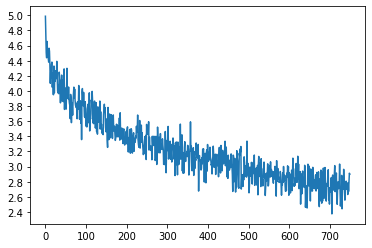

In [19]:
hidden_size = 250
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

Sau đó ta sẽ tiến hành thực hiện đánh giá.

In [20]:
evaluateRandomly(encoder1, attn_decoder1)

> so , starting with the political philosophy .
= bat dau voi triet ly chinh tri .
< bat dau voi voi benh . <EOS>

> it is a chess game .
= day la mot van co .
< day la mot van . . <EOS>

> do not really pay attention to them .
= cac ban dung chu y den chung .
< khong co y y nghia . <EOS>

> but take the example of heparin .
= nhung hay xem vi du ve heparin .
< hay xem xem ve vi du . <EOS>

> i do not want to explain these things .
= toi khong muon giai thich nhung thu nay .
< toi khong muon giai thich nhung . <EOS>

> but what do we do for a living ?
= nhung chung ta kiem song bang gi ?
< nhung song chung ta gi ? ? <EOS>

> alamieyeseigha was arraigned in london .
= alamieyeseigha bi buoc toi o london .
< toi dang o choi . <EOS>

> we somehow got to proteins and dna .
= chung ta co protein va dna .
< chung ta co duoc va va . <EOS>

> but we are not there yet .
= nhung ta chua dat toi do dau .
< nhung chung ta chua den dau . <EOS>

> thank you .
= cam on .
< cam on cac ban . <EOS>



**9) Hiển thị hóa attention**

Một đặc tính hữu ích của cơ chế attention đó là các đầu ra của nó rất dễ hiểu. Bởi vì nó được sử dụng để xử lý các giá trị đầu ra của encoder từ các chuỗi dữ liệu đầu vào, nhờ vào attention ta có thể biết hệ thống mạng đang tập trung ở đâu tại mỗi bước thời gian.

input = i know all the possibility .
output = toi biet biet do . <EOS>


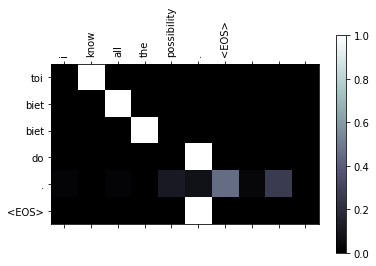

input = they kill me .
output = ho toi toi voi toi . <EOS>


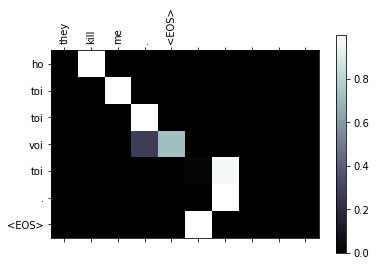

input = let me tell you a story .
output = de toi cho ban mot cau . <EOS>


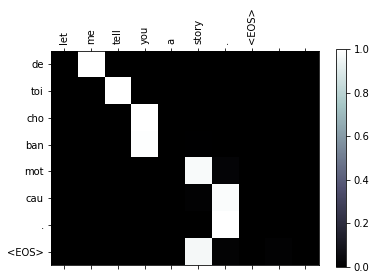

In [21]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

evaluateAndShowAttention(normalizeString("i know all the possibility .".lower().strip()))

evaluateAndShowAttention(normalizeString("they kill me .".lower().strip()))

evaluateAndShowAttention(normalizeString("let me tell you a story .".lower().strip()))

Appendix: Khu vực phục vụ cho việc debug.

In [0]:
%debug

> <ipython-input-11-161349bbca0c>(3)<listcomp>()
      1 def indexesFromSentence(lang, sentence):
      2     # Get the counter for each word in the sentence
----> 3     return [lang.word2index[word] for word in sentence.split(' ')]
      4 
      5 

ipdb> print(p) for p in lang.word2index
*** SyntaxError: invalid syntax
ipdb> lang.word2index
{'I': 2, 'was': 3, 'so': 4, 'shocked': 5, '.': 6, 'But': 7, 'many': 8, 'die': 9, 'These': 10, 'girls': 11, 'were': 12, 'lucky': 13, 'lost': 14, 'all': 15, 'hope': 16, 'Thank': 17, 'you': 18, 'Remi': 19, 'knows': 20, 'what': 21, 'love': 22, 'is': 23, 'He': 24, 'has': 25, 'the': 26, 'most': 27, 'impeccable': 28, 'memory': 29, 'a': 30, 'selective': 31, 'one': 32, ',': 33, 'though': 34, 'people': 35, 'don': 36, '&apos;t': 37, 'agree': 38, 'screamed': 39, 'lot': 40, 'Extraordinary': 41, 'You': 42, 'can': 43, 'be': 44, 'extraordinary': 45, 'Sometimes': 46, 'create': 47, 'potholes': 48, 'with': 49, 'that': 50, 'Ha': 51, '&apos;s': 52, 'ready': 53, 'So':